<h1>Programas de las Elecciones generales en España 2019 - #28A<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Motivación" data-toc-modified-id="Motivación-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Motivación</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Carga-de-datos" data-toc-modified-id="Carga-de-datos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Carga de datos</a></span><ul class="toc-item"><li><span><a href="#Fuentes-de-datos" data-toc-modified-id="Fuentes-de-datos-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fuentes de datos</a></span></li><li><span><a href="#Funciones-para-web-scrapping" data-toc-modified-id="Funciones-para-web-scrapping-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Funciones para web scrapping</a></span></li><li><span><a href="#Funciones-para-parseo-de-PDF" data-toc-modified-id="Funciones-para-parseo-de-PDF-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Funciones para parseo de PDF</a></span></li><li><span><a href="#Funciones-para-parseo-de-Excel" data-toc-modified-id="Funciones-para-parseo-de-Excel-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Funciones para parseo de Excel</a></span></li><li><span><a href="#Control-de-la-carga" data-toc-modified-id="Control-de-la-carga-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Control de la carga</a></span></li></ul></li><li><span><a href="#Obtención-y-preprocesamiento-del-texto" data-toc-modified-id="Obtención-y-preprocesamiento-del-texto-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Obtención y preprocesamiento del texto</a></span><ul class="toc-item"><li><span><a href="#Stop-words" data-toc-modified-id="Stop-words-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Stop words</a></span></li></ul></li><li><span><a href="#Nubes-de-palabras" data-toc-modified-id="Nubes-de-palabras-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Nubes de palabras</a></span><ul class="toc-item"><li><span><a href="#Nubes-de-palabras-por-frecuencia" data-toc-modified-id="Nubes-de-palabras-por-frecuencia-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Nubes de palabras por frecuencia</a></span></li></ul></li><li><span><a href="#Preocupaciones-de-los-españoles" data-toc-modified-id="Preocupaciones-de-los-españoles-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Preocupaciones de los españoles</a></span><ul class="toc-item"><li><span><a href="#Encuesta-del-CIS" data-toc-modified-id="Encuesta-del-CIS-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Encuesta del CIS</a></span></li><li><span><a href="#Reflejo-en-los-programas-electorales" data-toc-modified-id="Reflejo-en-los-programas-electorales-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Reflejo en los programas electorales</a></span></li></ul></li><li><span><a href="#Líneas-futuras-de-trabajo" data-toc-modified-id="Líneas-futuras-de-trabajo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Líneas futuras de trabajo</a></span></li><li><span><a href="#Referencias" data-toc-modified-id="Referencias-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Referencias</a></span></li></ul></div>

# Motivación

Estamos en los últimos días de la campaña electoral previa a las Elecciones Generales en España, y los partidos políticos tratan de convencer a los no pocos indecisos.

En este notebook voy a analizar algunos aspectos de los programas electorales de los principales partidos políticos españoles (en cuanto a intención de voto según las últimas encuestas realizadas).

NOTA: Por supuesto que no me he leído los programas; nadie cumple lo que promete :)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multidict as multidict
import plotly_express as px
import string
import requests
import textract
import nltk

from bs4 import BeautifulSoup as bso
from os import path
from tika import parser, config
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from stop_words import get_stop_words

In [3]:
%matplotlib inline
sns.set()

# Carga de datos

## Fuentes de datos

**Programas electorales** comparados:
* [PSOE](https://www.psoe.es/programa-electoral/) (completo, pdf)
* [Ciudadanos](https://www.ciudadanos-cs.org/programa-electoral) (completo, web)
* [PP](https://www.pp.es/conocenos/programas) (completo, pdf)
* [Vox](https://www.voxespana.es/espana/programa-electoral) (*"completo"*, pdf)
* [Unidas Podemos](https://podemos.info/programa/) (completo, pdf)

**Datos del [CIS](http://www.analisis.cis.es/cisdb.jsp)**:
* Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls
* Problemas_sociales_que_personalmente_afectan_mas_3_ordinal.xls

In [4]:
# Programs
program_path = 'data/full/'
cs_web = 'https://www.ciudadanos-cs.org/programa-electoral'

# Logos
logo_path = 'img/logos/'

## Funciones para web scrapping

Funciones utilizadas para obtener los programas que no están en PDF. Usaremos `BeautifulSoup` para obtener todo el texto de la web correspondiente:

In [5]:
def parse_web_program(party):
    if party == 'ciudadanos':
        raw_txt = parse_cs_program()
        txt_path = program_path + party + '.txt'
        with open(txt_path, 'w') as f:
           f.write(raw_txt)
        return raw_txt
    else:
        raise Error

def parse_cs_program():
    html_doc = requests.get(cs_web)
    soup = bso(html_doc.text, 'html.parser')
    raw_txt = ""
    
    contents = soup.select('.propuesta')
    for content in contents:
        raw_txt += content.select('.titulo')[0].get_text() + ' '
        for h3 in content.select('h3'):
            raw_txt += h3.get_text() + ' '
        for li in content.select('li'):
            raw_txt += li.get_text() + ' '
    return raw_txt

## Funciones para parseo de PDF

Para obtener el texto de los PDFs usaremos el comando `pdftotext`; después de haber probado `tika` y `textract` con peores resultados:

In [6]:
def parse_pdf_program(party, first=1):
    pdf_path = program_path + party + '.pdf'
    txt_path = program_path + party + '.txt'

    !pdftotext -f $first -nopgbrk $pdf_path

    return str(parser.from_file(txt_path)['content'])

## Funciones para parseo de Excel

Para parsear los ficheros Excel obtenidos de la web de CIS usaremos directamente `pandas`:

In [7]:
cis_xls = f'data/cis/Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls'
cis_xls2 = f'data/cis/Problemas_sociales_que_personalmente_afectan_mas_3_ordinal.xls'
def parse_cis_excel():
    df = pd.read_excel(cis_xls, skiprows=6, usecols=[0, 4], nrows=42)
    df.columns = ['problem', 'concern']
    return df.sort_values(by='concern', ascending=False)

## Control de la carga

Función para obtener el programa electoral dependiendo de cada partido:

In [8]:
def get_program(party):
    party = party.lower()
    if party == 'ciudadanos':
        return parse_web_program('ciudadanos')
    elif party == 'psoe':
        return parse_pdf_program('psoe', 8)
    elif party == 'unidas_podemos':
        return parse_pdf_program('unidas_podemos', 5)
    elif party == 'pp':
        return parse_pdf_program('pp', 6)
    elif party == 'vox':
        return parse_pdf_program('vox', 1)
    else:
        raise NotImplementedError('Party not found: ' + party)

Aquí es donde indicamos los partidos a comparar:

In [9]:
parties = ['pp', 'ciudadanos', 'vox', 'psoe', 'unidas_podemos']

# Obtención y preprocesamiento del texto

Creamos funciones para preprocesar el texto:
* eliminar los caracteres que nos sobran
* pasar todo a minúsculas
* aplicar word stemming (experimental; no funciona del todo bien)

In [10]:
def simple_stemmer(text):
    #stemmer = nltk.porter.PorterStemmer()
    stemmer = nltk.stem.SnowballStemmer('spanish')
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [11]:
def preprocess_raw_text(raw_txt):
    fix_txt = raw_txt.replace('\r\n', '').lower()
    #fix_txt = simple_stemmer(raw_txt.replace('\r\n', '').lower())
    #print(fix_txt)
    return fix_txt

Obtenemos el texto de los programas de todos los partidos y lo preprocesamos:

In [12]:
programs_txt = {}
for party in parties:
    programs_txt[party] = preprocess_raw_text(get_program(party))

## Stop words

Como estamos procesando lenguaje natural (aunque sea jerga política) tendremos algunas palabras que se repiten mucho, como en cualquier texto; por ejemplo pronombres, preposiciones, conjunciones, etc. La idea es quitarlas para que no interfieran en nuestro análisis.

Vamos a tirar de una lista ya existente:

In [13]:
stopwords = get_stop_words('es')
print(stopwords)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

Además vamos a añadir algunas palabras más que también aparecen bastante en algún programa y que no aportan mucho semánticamente...

In [14]:
stopwords.extend(['así', 'pág', 'ello', 'año', 'años', 'manera', 'forma', 'cualquier', 
                 'ser', 'cada', 'solo'])

# Nubes de palabras

Vamos a analizar las palabras más usadas por cada partido en su programa electoral. Para ello usaremos un recurso muy visual: las nubes de palabras, donde se refleja la frecuencia relativa de las más utilizadas.

Usaremos la librería `word_cloud` para generar dichas nubes:

In [15]:
def generate_word_cloud(input, party):     
    
    mask = np.array(Image.open(logo_path + party + '.png'))
    
    wc = WordCloud(background_color="white", max_words=300, mask=mask,
                   width=900, height=450, min_font_size=7, max_font_size=100,
                   stopwords=stopwords, collocations=True, normalize_plurals=True,
                   #contour_width=3, contour_color='steelblue', colormap='viridis',
                   prefer_horizontal=1)
    
    if isinstance(input, str):
        wc.generate(input)
    else:
        wc.generate_from_frequencies(input)

    plt.figure(figsize=(30,14))
    plt.imshow(wc.recolor(color_func=ImageColorGenerator(mask)), interpolation="bilinear")
    plt.axis("off")
    plt.show();
    
    #plt.savefig('img/clouds/'+party+'_new.png', format="png")
    
    return wc

Podemos crear una nube de palabras dejando todo en manos de la librería word_cloud, que se encargará de signos de puntuación, plurales, bigramas, etc.

In [16]:
wcs = {}
for party in parties[0:0]:
    print(party.upper())
    wcs[party] = generate_word_cloud(programs_txt[party], party)

Y con esto veríamos el peso relativo de cada palabra, de mayor a menor importancia:

In [17]:
for party in parties[0:0]:
    print(party.upper())
    wcs[party].words_

NOTA: No hay resultado porque los bucles están *desactivados*. Después de realizar varias pruebas y comprobaciones es preferible usar otra variante, para controlar un poco más el proceso y no obtener cosas raras...

## Nubes de palabras por frecuencia

Ahora vamos a crear las nubes de palabras pero sin dejar todo en manos de la librería word_cloud. Para cada programa electoral primero crearemos un diccionario con todas las palabras y el número de apariciones de cada una, de tal forma que también podamos jugar más adelante con esos datos.

Adicionalmente imprimiremos el número de apariciones de las 50 palabras más frecuentes en cada programa electoral.

NOTA: Eliminaremos signos de puntuación y palabras con menos de 3 caracteres.

In [18]:
# Punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
def get_frequency_dict(input_txt):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # Missing '+'? expecting 'I+D'...
    clr_txt = input_txt.translate(str.maketrans('!"#$%&\'()*,-./:;<=>?@[\\]^_`{|}~',
                                              '                               '))
    # making dict for counting frequencies
    for text in clr_txt.split(" "):
        if text not in stopwords and len(text) > 2:
            val = tmpDict.get(text, 0)
            tmpDict[text] = val + 1

    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    
    return fullTermsDict

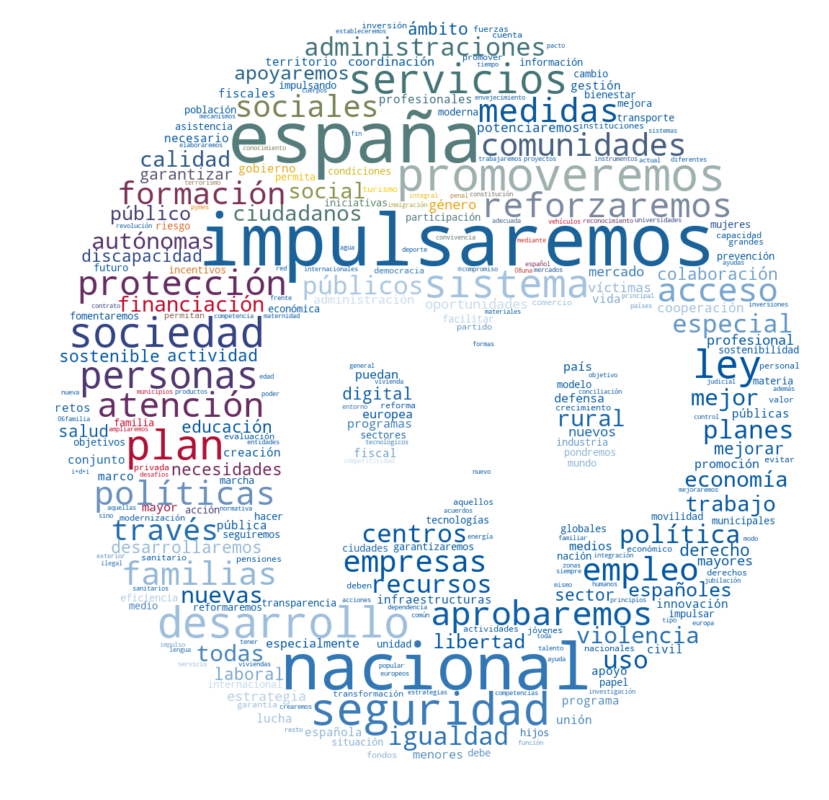

PP
impulsaremos: 95 | españa: 94 | nacional: 76 | promoveremos: 76 | seguridad: 71 | desarrollo: 64 | sociedad: 60 | plan: 60 | servicios: 58 | sistema: 55 | ley: 54 | personas: 49 | protección: 49 | reforzaremos: 47 | atención: 47 | aprobaremos: 46 | acceso: 46 | medidas: 44 | políticas: 44 | empleo: 43 | familias: 43 | comunidades: 42 | formación: 41 | empresas: 40 | sociales: 40 | través: 39 | administraciones: 39 | política: 38 | especial: 38 | planes: 38 | públicos: 37 | recursos: 37 | uso: 37 | centros: 37 | igualdad: 36 | autónomas: 36 | nuevas: 35 | mejor: 34 | rural: 34 | todas: 34 | violencia: 34 | ciudadanos: 33 | calidad: 32 | social: 32 | economía: 32 | trabajo: 31 | financiación: 31 | apoyaremos: 31 | españoles: 30 | libertad: 30 | 

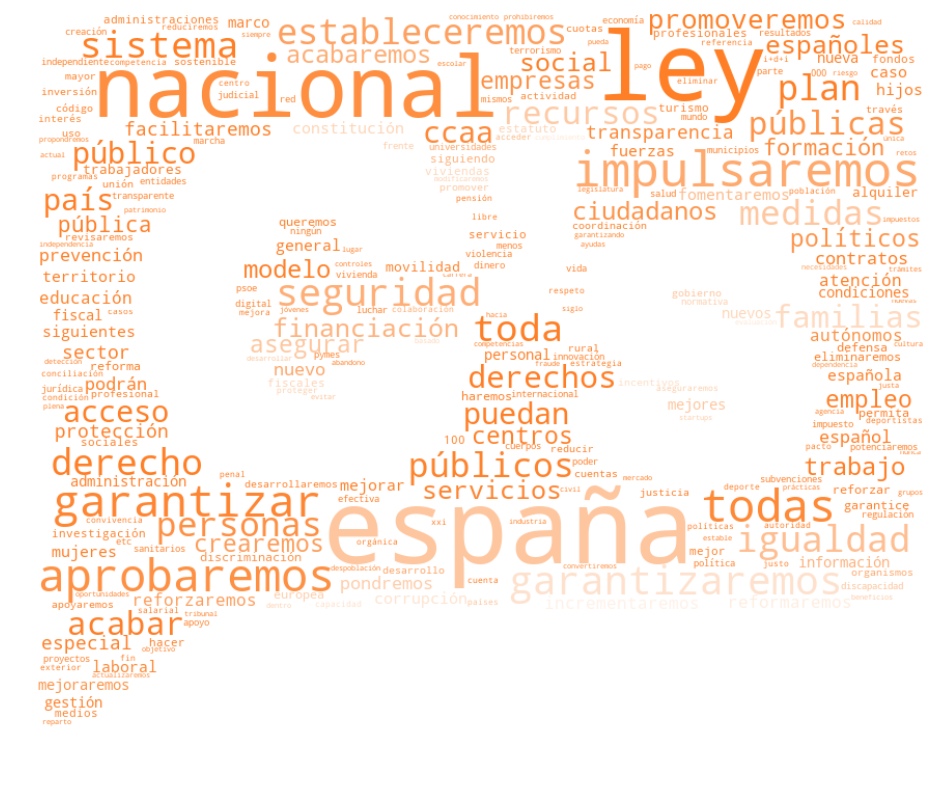

CIUDADANOS
españa: 72 | ley: 60 | nacional: 47 | impulsaremos: 39 | aprobaremos: 35 | todas: 35 | garantizar: 33 | garantizaremos: 30 | seguridad: 29 | toda: 28 | sistema: 28 | igualdad: 27 | derecho: 27 | estableceremos: 26 | plan: 26 | públicos: 25 | medidas: 25 | personas: 25 | públicas: 22 | recursos: 22 | acabar: 22 | derechos: 21 | familias: 21 | público: 20 | puedan: 20 | ccaa: 20 | acceso: 20 | país: 20 | promoveremos: 20 | financiación: 19 | españoles: 19 | servicios: 19 | social: 19 | ciudadanos: 18 | modelo: 18 | acabaremos: 18 | trabajo: 18 | asegurar: 17 | políticos: 17 | empleo: 17 | crearemos: 17 | empresas: 17 | centros: 17 | formación: 16 | pública: 15 | transparencia: 15 | protección: 15 | sector: 15 | especial: 15 | facilitaremos: 15 | 

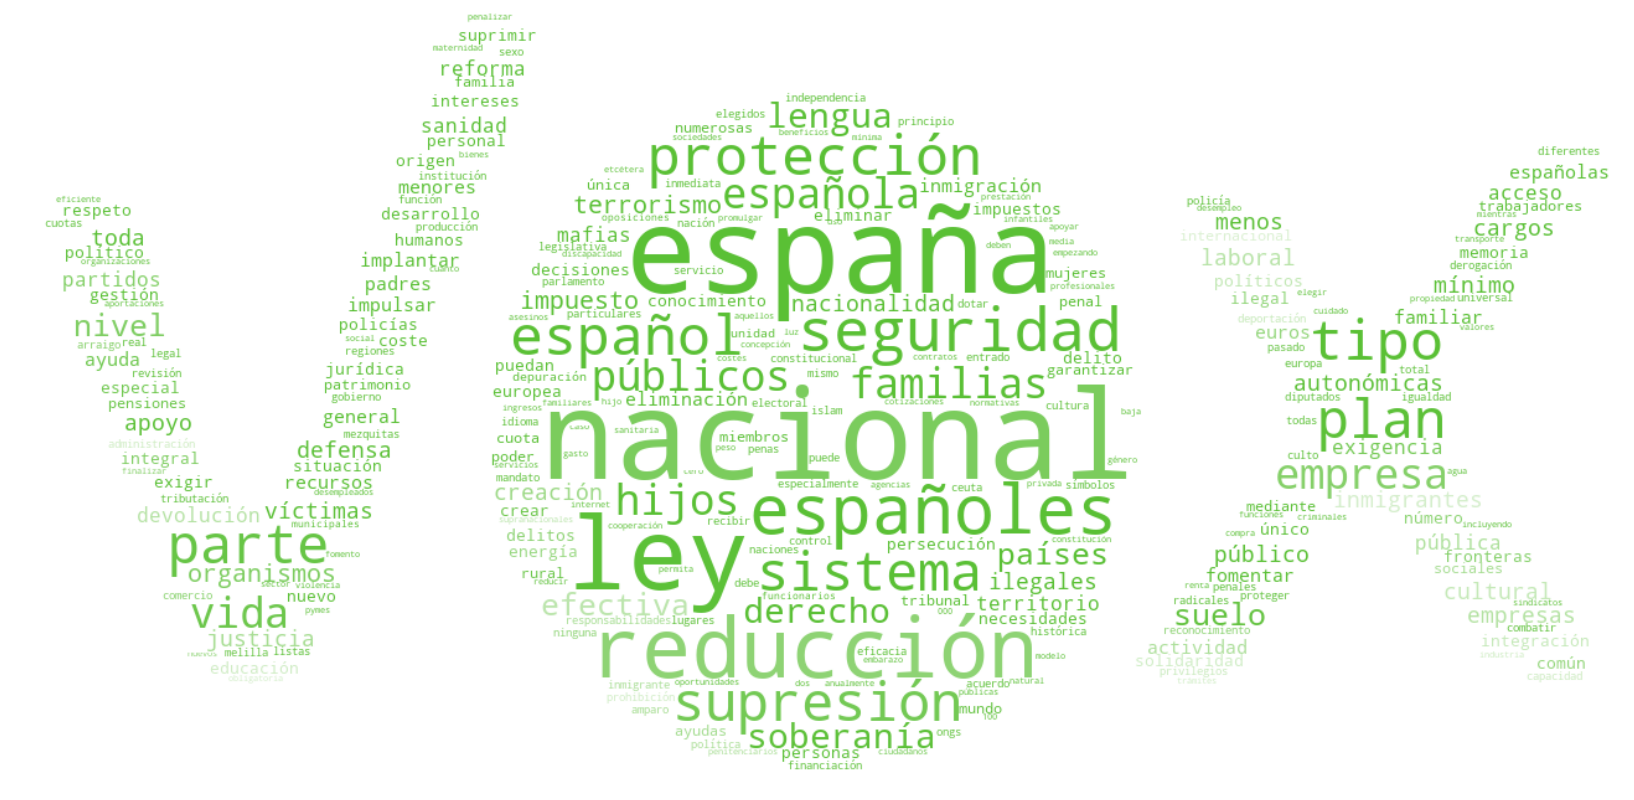

VOX
nacional: 16 | españa: 15 | ley: 10 | reducción: 9 | españoles: 8 | seguridad: 8 | protección: 7 | español: 7 | tipo: 7 | supresión: 7 | plan: 7 | sistema: 7 | parte: 7 | públicos: 7 | vida: 7 | española: 7 | empresa: 7 | familias: 7 | hijos: 7 | soberanía: 6 | lengua: 6 | derecho: 6 | efectiva: 6 | países: 6 | nivel: 6 | suelo: 6 | organismos: 6 | impuesto: 6 | terrorismo: 6 | menos: 5 | autonómicas: 5 | toda: 5 | justicia: 5 | cargos: 5 | inmigrantes: 5 | ilegales: 5 | empresas: 5 | nacionalidad: 5 | víctimas: 5 | defensa: 5 | público: 5 | mínimo: 5 | apoyo: 5 | laboral: 5 | creación: 5 | cultural: 5 | partidos: 4 | acceso: 4 | pública: 4 | devolución: 4 | 

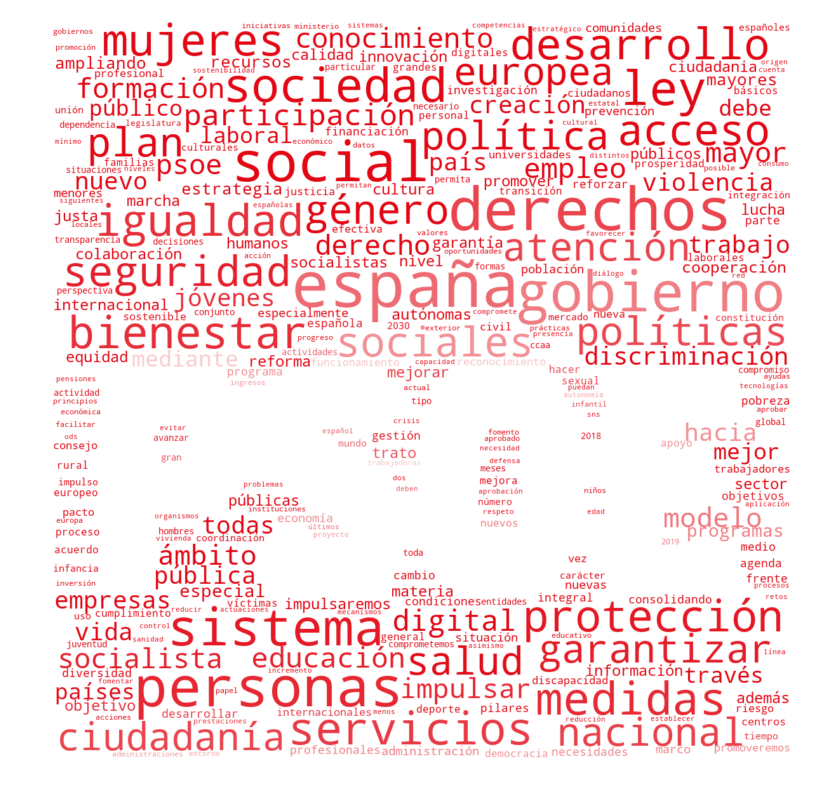

PSOE
españa: 242 | derechos: 212 | gobierno: 186 | personas: 184 | social: 179 | sistema: 156 | ley: 133 | sociedad: 130 | medidas: 120 | servicios: 120 | bienestar: 118 | igualdad: 116 | protección: 116 | mujeres: 115 | desarrollo: 111 | acceso: 109 | seguridad: 106 | sociales: 103 | género: 97 | plan: 97 | políticas: 95 | política: 94 | garantizar: 94 | nacional: 90 | atención: 89 | salud: 88 | ciudadanía: 85 | europea: 84 | participación: 82 | digital: 79 | empleo: 77 | educación: 77 | formación: 75 | psoe: 74 | mayor: 73 | derecho: 72 | conocimiento: 72 | socialista: 71 | impulsar: 69 | ámbito: 68 | modelo: 67 | discriminación: 67 | hacia: 65 | empresas: 64 | creación: 64 | vida: 63 | todas: 62 | trabajo: 62 | jóvenes: 61 | violencia: 61 | 

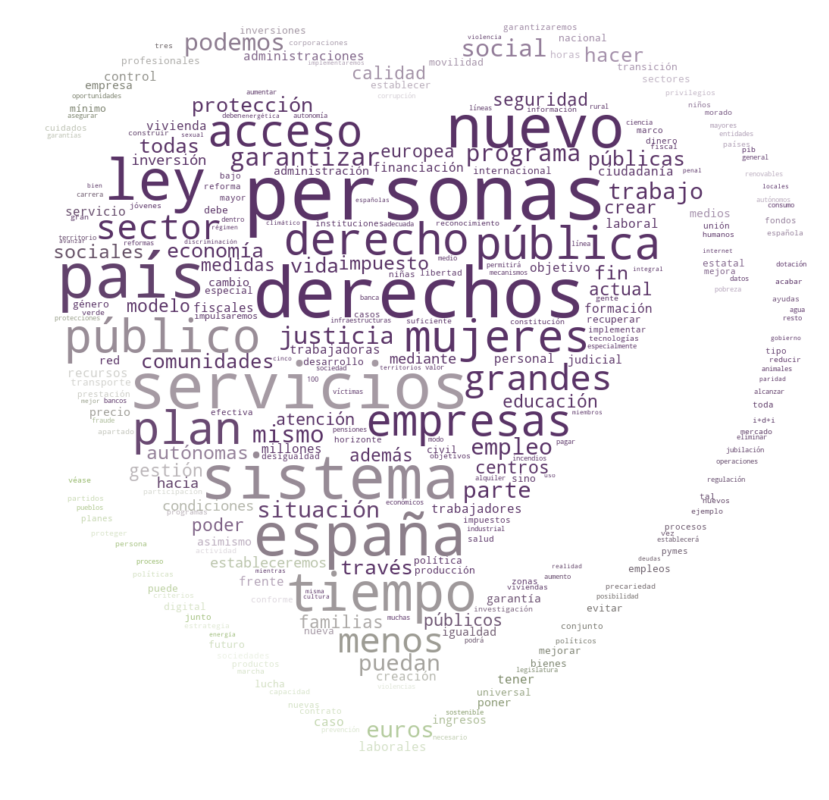

UNIDAS_PODEMOS
personas: 93 | derechos: 78 | servicios: 64 | país: 61 | sistema: 60 | nuevo: 56 | españa: 56 | ley: 52 | tiempo: 47 | público: 44 | plan: 43 | pública: 42 | mujeres: 41 | derecho: 41 | acceso: 40 | empresas: 40 | grandes: 39 | menos: 39 | sector: 38 | garantizar: 38 | podemos: 36 | justicia: 36 | social: 36 | mismo: 34 | programa: 34 | parte: 31 | euros: 31 | trabajo: 31 | empleo: 30 | situación: 30 | puedan: 30 | protección: 30 | vida: 29 | todas: 29 | economía: 29 | públicas: 29 | través: 28 | comunidades: 28 | hacer: 28 | impuesto: 28 | fin: 27 | sociales: 27 | autónomas: 27 | seguridad: 27 | modelo: 26 | poder: 26 | actual: 26 | europea: 26 | educación: 26 | medidas: 25 | 

In [20]:
freq_dicts = {}
wcs = {}

for party in parties:
    
    # Generate frequencies dict
    freq_dicts[party] = get_frequency_dict(programs_txt[party])

    # Generate word cloud. NOTE: neither bigrams nor normalization with this approach
    wcs[party] = generate_word_cloud(freq_dicts[party], party)
    
    # Print Top 50 words with frequency
    print(party.upper())
    for key in sorted(freq_dicts[party], key=freq_dicts[party].get, reverse=True)[:50]:
        print('{}: {}'.format(key, freq_dicts[party][key]), end=' | ')
    

**¿Es lo que esperabas?**

Con ésto podemos hacernos una idea de los temas más importantes en cada programa. A poco que conozcas de qué pie cojea cada uno, comprobarás que más o menos con la nube de palabras del programa tenemos una radiografía del partido.

Quizá podríamos prescindir de palabras comunes como *España*, ya que es normal que aparezca mucho estando en el país que estamos. Pero para el análisis completo resulta interesante conservar todo. ¿No resulta curioso ver que Unidas Podemos es el único partido donde *España* no aparece en el Top 2? Ellos usan la palabra *país* con tanta frecuencia como la anterior. Igual lo que no esperabas es que el PSOE usaría *España* más que los partidos de derecha.

¡Pues sí que ha dado juego una palabra que pensábamos que no aportaba nada! te invito a que busques palabras más interesantes como *derechos*, *ley*, *sanidad*, *educación*, *impuestos*, *empleo*, *corrupción*, ....

# Preocupaciones de los españoles

¿Para qué están los políticos? es una buena pregunta. Supuestamente representan a los votantes, y en teoría los programas electorales deberían intentar recoger soluciones a los problemas más importantes, tanto de la mayoría como de las múltiples minorías. Bueno, sabiendo que los partidos más grandes se van a centrar en el interés general (de verdad que lo siento por esas minorías), su programa debería reflejar cuáles son sus propuestas para las mayores preocupaciones del votante medio. ¿O no?

El CIS realiza mensualmente una encuesta donde pregunta a una muestra de la población cuáles son los 3 problemas que más les preocupan, y ofrece los resultados de forma abierta; lo que nos sirve para hacernos una idea del interés general. Parece un buen punto de partida. ¿O no?

Vamos a intentar averiguar si la importancia que dan a estos temas los votantes es la misma que la que le dan los partidos políticos...

## Encuesta del CIS

Vamos a cargar los datos del CIS de la última encuesta realizada. Usaremos un dataframe de pandas:

In [21]:
cis_df = parse_cis_excel()

Dibujamos una gráfica interactiva de barras horizontales para visualizar los datos, usando `plotly_express`:

In [22]:
px.bar(
    cis_df, x="concern", y="problem", template="plotly_white",
    labels=dict(concern="% de encuestados para los que el problema es Top 3", problem="Problema"),
    width=1000, height=800, title="Principales (3) preocupaciones de los españoles [marzo 2019]",
    orientation='h'
)

El paro, la corrupción, el fraude, la clase política, la economía, sanidad, educación, ... nada nuevo. Pero siempre es importante ver las cifras. Sólo los 18 principales problemas superan el 1% de personas para las que su preocupación está en el Top 3. Pero está claro que el medioambiente le preocupa a más de un 0,8% de la población, ¿verdad? (espero) aunque sólo para ese pequeño grupo sea algo primordial.

Hay mucha diferencia entre el primer problema y el segundo. Entre los 4 primeros y todos los demás. Pues a ver qué dicen los programas electorales...

## Reflejo en los programas electorales

Vamos a crear un diccionario con una entrada para cada uno de los principales problemas según la encuesta del CIS. Y para cada entrada hacemos una lista con algunas de las palabras más significativas que esperaríamos encontrar relacionadas con el tema de la entrada en cuestión.

Esta parte es bastante delicada, porque hay palabras que podrían relacionarse con varios temas, y habrá que valorar su inclusión en una lista o en otra (o en ninguna). Por ejemplo, seguramente una de las primeras palabras que nos viene a la mente cuando hablamos de `violencia_machista` es *género*, pero está claro que también se puede hablar de *género* relacionado simplemente con `mujer` (desigualdades).

NOTA: algunos temas han sido unidos, como por ejemplo Cataluña y los nacionalismos.

In [23]:
problems = {'empleo': ['paro', 'paradas', 'parados', 'parada', 'parado', 'empleo', 'desempleado',
                       'desempleada', 'desempleados', 'desempleo'],
            'corrupción': ['corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 
                           'imputados', 'imputado'],
            'fraude': ['fraude', 'defraudan', 'defraudado', 'defraudador', 'defraudadores'],
            'economía': ['economía', 'pib', 'económica', 'crisis', 'mercado', 'euro', 'eeconómico'],
            'sanidad': ['sanidad', 'médico', 'médicos', 'quirófano', 'hospital'],
            'educación': ['educación', 'enseñanza', 'escuela', 'idiomas', 'profesores'],
            'cataluña': ['cataluña', 'catalanes', 'referéndum', '155', 'independencia', 'independentistas', 
                         'nacionalismo', 'nacionalismos', 'separatistas', 'separatismo', 'soberanía'],
            'social': ['social', 'equitativa', 'equitativo', 'sociales'],
            'pensiones': ['pensiones', 'pensión', 'jubilación', 'pensionistas', 'pensionista', 'jubilado', 
                          'jubilados'],
            'inmigración': ['inmigración', 'inmigrante', 'inmigrantes', 'extranjero', 'extranjeros', 
                            'refugiados'],
            'violencia_machista': ['machista', 'machistas', 'acoso', 'violación', 'violada', 'violadas', 
                                   'maltrato', 'maltratada', 'maltratadas'],
            'inestabilidad': ['inestabilidad', 'pactos', 'pacto', 'acuerdos', 'desacuerdos'],
            'inseguridad': ['inseguridad', 'ciberseguridad', 'policía', 'violentos', 'crímenes', 'robos'],
            'vivienda': ['vivienda', 'alquiler', 'alquileres', 'hipoteca', 'hipotecas', 'especulación', 
                         'especuladores', 'buitre', 'buitres', 'desahucio', 'desahucios', 'okupa', 'okupas'],
            'justicia': ['justicia', 'jueces', 'juez', 'juicio', 'juicios', 'sentencia', 'prisión', 'cárcel'],
            'valores': ['valores', 'familia', 'aborto', 'tradiciones', 'tradición'],
            'mujer': ['mujer', 'mujeres', 'feminismo', 'feminismos'],
            'medioambiente': ['medioambiente', 'medioambiental', 'planeta', 'contaminación', 'contaminantes', 
                              'reciclar', 'renovables', 'climático'],
            'juventud': ['juvenil', 'juventud', 'jóvenes'],
            'infraestructuras': ['infraestructura', 'infraestructuras', 'carreteras', 'trenes', 
                                 'ave', 'ferroviaria', 'puentes', 'autopistas'],
            'impuestos': ['impuestos', 'impuesto', 'iva', 'irpf', 'sucesiones'],
            'inversión': ['i+d', 'i+d+i', 'inversión', 'inversiones', 'invertir', 'invierte'],
            'monarquía': ['monarquía', 'reyes', 'república', 'rey'],
            'autónomos': ['autónomos'],
            'racismo': ['racismo', 'racista', 'racistas', 'xenofobia', 'xenófobo', 'xenófobos'],
            'drogas': ['droga', 'drogas', 'heroína', 'cocaína'],
            'agric_ganad_pesca': ['agrario', 'agraria', 'agricultura', 'agricultor', 'agricultores', 
                                  'ganadería', 'ganadero', 'ganaderos', 'pesca', 'pescadores', 'pescador'],
            'terrorismo': ['terrorismo', 'terrorista', 'terroristas', 'isis', 'eta']
            }

Vamos a contar el número de palabras en cada programa electoral (eliminadas stop words y palabras menores de 3 letras), ya que aparte de contar el número de apariciones de una palabra relacionada con cada problema, nos interesa saber la frecuencia, de tal forma que podamos ver la importancia en cada programa y lanzar una comparativa entre todos.

In [24]:
program_words = {}
for party in parties:
    program_words[party] = sum(freq_dicts[party].values())

program_words

{'pp': 14499,
 'ciudadanos': 7479,
 'vox': 1824,
 'psoe': 33127,
 'unidas_podemos': 14811}

Creamos un dataframe con el conteo de palabras asociadas a cada problema, para cada partido:

In [25]:
df = pd.DataFrame(columns=problems.keys())

for party in parties:
    counts_array = []
    for problem in problems.keys():
        counts = 0
        for word in problems.get(problem):
            counts += freq_dicts[party].get(word, 0)
        counts_array.append(counts)
    df.loc[party] = counts_array

df['TOTAL_PALABRAS'] = program_words.values()
df.T

pp ciudadanos   vox   psoe unidas_podemos
empleo                 52         24     5     94             40
corrupción              0         15     0     12             13
fraude                  1          6     0      5             13
economía               79         22     3    135             75
sanidad                 9          9     4     27              8
educación              32         15     5     89             33
cataluña               21         16     9     19             19
social                 72         31     5    288             63
pensiones              34         15     4     34             30
inmigración            21         10    11     41              9
violencia_machista      8          5     0      7             15
inestabilidad          26         10     0     61              9
inseguridad            21          4     4     20              5
vivienda               21         20     2     32             48
justicia               19         15     6     40             44
valores                24          7     7     38             13
mujer                  22         16     4    128             46
medioambiente          22         10     0     50             28
juventud               18          6     1     97             20
infraestructuras       25         10     1     17             16
impuestos              23         25    12      9             55
inversión              40         19     2     56             54
monarquía               0          0     0      3              4
autónomos               6         13     1     10             11
racismo                 2          1     0     12              2
drogas                  3          1     0     11              0
agric_ganad_pesca      12          4     0     13             17
terrorismo             19         11    10     15              0
TOTAL_PALABRAS      14499       7479  1824  33127          14811

**¿Algo interesante por aquí?**

Así, de primeras:
* Segunda preocupación de los españoles: la corrupción. El programa del PP no usa ninguna de estas palabras: 'corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 'imputados', 'imputado'. En casi 15.000 palabras parece que no había sitio para la segunda preocupación de los españoles. Curioso cuando supuestamente quieren romper con el pasado del partido en este tema. Tampoco aparece en el programa de Vox, lo que resulta aún más preocupante tratándose de un partido nuevo.
* Tercera preocupación: el fraude. El programa del PP usa una única vez alguna de estas palabras: 'fraude', 'defraudan', 'defraudado', 'defraudador', 'defraudadores'. Si vas al programa esto es todo lo que encontrarás sobre el tema: *'Reforzaremos las políticas de lucha contra el fraude fiscal, potenciando el uso de los medios humanos y tecnológicos'*. Vox ni eso. Bravo.
* El programa de Vox parece no hablar de violencia machista. Buscando por la palabra *género*, sacada a propósito de esa categoría, encontramos una promesa electoral: derogar la ley de violencia de ídem (supongo que los españoles están preocupados por su existencia...). Nada de medioambiente, ni de agricultura, ganadería o pesca. Great...

Y después de ver las anomalías, y asegurarnos de que nuestro código está bien, vamos a pasar a frecuencias para poder analizar mejor los resultados. Creamos otro dataframe diviendo el número de apariciones de los temas en cada programa por el número de palabras total.

In [26]:
df_rel = df.div(0.01*df['TOTAL_PALABRAS'], axis=0).drop('TOTAL_PALABRAS', axis=1)
df_rel.T

pp ciudadanos        vox        psoe  \
empleo                0.358645   0.320899   0.274123    0.283756   
corrupción                   0   0.200562          0   0.0362242   
fraude              0.00689703  0.0802246          0   0.0150934   
economía              0.544865   0.294157   0.164474    0.407523   
sanidad              0.0620732   0.120337   0.219298   0.0815045   
educación             0.220705   0.200562   0.274123    0.268663   
cataluña              0.144838   0.213932   0.493421    0.057355   
social                0.496586   0.414494   0.274123    0.869381   
pensiones             0.234499   0.200562   0.219298    0.102635   
inmigración           0.144838   0.133708    0.60307    0.123766   
violencia_machista   0.0551762  0.0668539          0   0.0211308   
inestabilidad         0.179323   0.133708          0     0.18414   
inseguridad           0.144838  0.0534831   0.219298   0.0603737   
vivienda              0.144838   0.267415   0.109649   0.0965979   
justicia              0.131044   0.200562   0.328947    0.120747   
valores               0.165529  0.0935954   0.383772     0.11471   
mujer                 0.151735   0.213932   0.219298    0.386392   
medioambiente         0.151735   0.133708          0    0.150934   
juventud              0.124146  0.0802246  0.0548246    0.292813   
infraestructuras      0.172426   0.133708  0.0548246   0.0513177   
impuestos             0.158632   0.334269   0.657895   0.0271682   
inversión             0.275881   0.254045   0.109649    0.169046   
monarquía                    0          0          0  0.00905606   
autónomos            0.0413822    0.17382  0.0548246   0.0301869   
racismo              0.0137941  0.0133708          0   0.0362242   
drogas               0.0206911  0.0133708          0   0.0332055   
agric_ganad_pesca    0.0827643  0.0534831          0   0.0392429   
terrorismo            0.131044   0.147078   0.548246   0.0452803   

                   unidas_podemos  
empleo                    0.27007  
corrupción              0.0877726  
fraude                  0.0877726  
economía                  0.50638  
sanidad                 0.0540139  
educación                0.222807  
cataluña                 0.128283  
social                    0.42536  
pensiones                0.202552  
inmigración             0.0607656  
violencia_machista       0.101276  
inestabilidad           0.0607656  
inseguridad             0.0337587  
vivienda                 0.324083  
justicia                 0.297076  
valores                 0.0877726  
mujer                     0.31058  
medioambiente            0.189049  
juventud                 0.135035  
infraestructuras         0.108028  
impuestos                0.371346  
inversión                0.364594  
monarquía                0.027007  
autónomos               0.0742691  
racismo                 0.0135035  
drogas                          0  
agric_ganad_pesca         0.11478  
terrorismo                      0

Y creamos una gráfica de barras horizontales agrupadas, para poder comparar los 5 partidos en cada uno de los temas por separado (algo posible gracias a la normalización previa). El orden de los problemas está ordenado por la importancia reflejada en la encuesta del CIS, de menor a mayor importancia. Lo que esperaríamos es encontrar como el tamaño de las barras es mayor según vamos descendiendo.

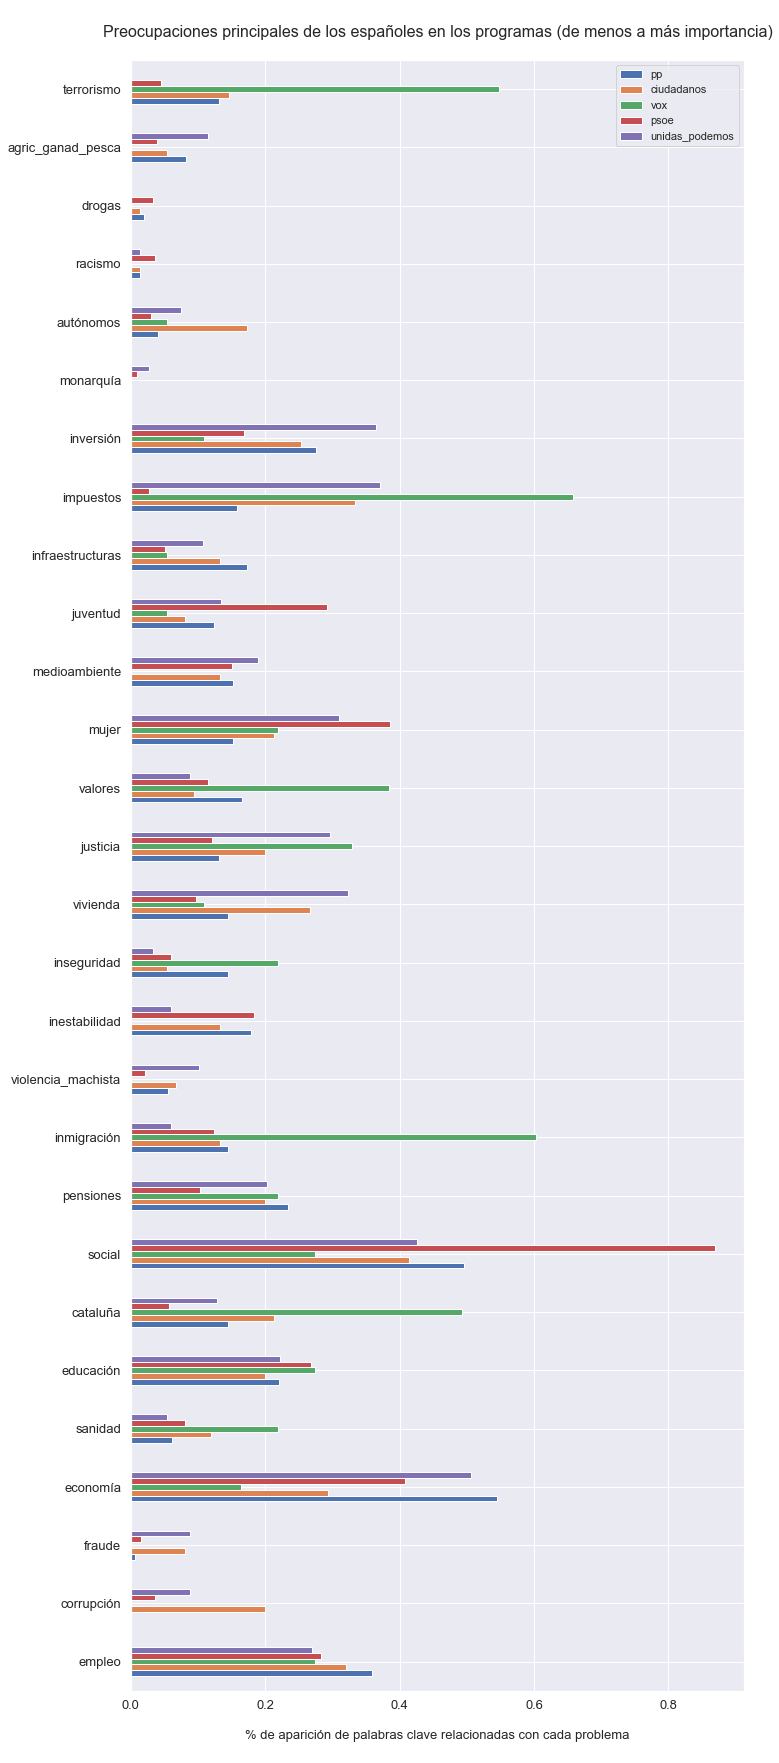

In [27]:
ax = df_rel.T.plot(kind='barh', figsize=(11,30), fontsize=13)

ax.set_title('\nPreocupaciones principales de los españoles en los programas (de menos a más importancia)\n', 
             fontsize=16)
ax.set_xlabel("\n% de aparición de palabras clave relacionadas con cada problema\n", fontsize=13);

**¿Llamativo?**

Desde luego que no parece seguir el patrón de preocupaciones de los votantes, sobre todo en temas de corrupción y fraude (posiciones 2 y 3); donde sólo Unidas Podemos y Ciudadanos parecen incidir (quizá algo previsto, pero no tan descarado).

Quizá después de este análisis no sabremos las medidas que explica cada programa, pero igual nos ha ayudado a descartar los que no necesitamos ni abrir.

# Líneas futuras de trabajo

Podríamos ampliar este análisis en varias direcciones:
* Comparativa con los programas electorales de las anteriores elecciones generales, para ver cómo han evolucionado. 
* Análisis de sentimiento. No sabemos si se habla de un determinado tema en una dirección o en la contraria.
* Uso de bigramas y trigramas para poder realizar un mejor análisis
* Análisis de discursos electorales

P.D.- Es una pena que los programas electorales se publiquen tan tarde y no haya tiempo para mucho más.

# Referencias
* [tika-python](https://github.com/chrismattmann/tika-python)
* [pdftotext](https://en.wikipedia.org/wiki/Pdftotext)
* [textract](https://textract.readthedocs.io/en/latest/)
* [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [word_cloud](https://amueller.github.io/word_cloud/)
* [plotly_express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d)